<a href="https://colab.research.google.com/github/ergul13/mr_akgul/blob/main/NBCL_Binary_Egitim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ultralytics pydicom -q

import os
import shutil
import zipfile
import pandas as pd
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from pydicom.pixel_data_handlers.util import apply_voi_lut

# --- DİZİN YAPILANDIRMASI ---
BASE_DIR = '/content/tubitak_data'
RAW_IMAGES_DIR = f'{BASE_DIR}/raw_images'
CROPPED_IMAGES_DIR = f'{BASE_DIR}/cropped_images'
RSNA_TEMP_DIR = f'{BASE_DIR}/rsna_temp'
INBREAST_RAW_DIR = f'{BASE_DIR}/inbreast_raw'

# --- DRIVE KAYNAKLARI ---
DRIVE_RSNA_ZIP = '/content/drive/MyDrive/rsna-breast-cancer-512-pngs.zip'
DRIVE_INBREAST_ZIP = '/content/drive/MyDrive/AllDICOMs.zip'
DRIVE_RSNA_CSV = '/content/drive/MyDrive/TUBITAK_TRAIN.csv'
DRIVE_INBREAST_CSV = '/content/drive/MyDrive/INbreast.csv'
YOLO_WEIGHTS_PATH = '/content/drive/MyDrive/Meme_Kanseri_Projesi/yolov8n.pt'
FINAL_CSV_PATH = '/content/drive/MyDrive/TUBITAK_MASTER_CROPPED.csv'

# Klasörleri Temizle/Oluştur
if os.path.exists(RAW_IMAGES_DIR): shutil.rmtree(RAW_IMAGES_DIR)
os.makedirs(RAW_IMAGES_DIR, exist_ok=True)
os.makedirs(CROPPED_IMAGES_DIR, exist_ok=True)
os.makedirs(RSNA_TEMP_DIR, exist_ok=True)
os.makedirs(INBREAST_RAW_DIR, exist_ok=True)

print("ROI ODAKLI VERİ İŞLEME HATTI (DÜZELTİLMİŞ)")
print(f"Model: {YOLO_WEIGHTS_PATH}")
print("------------------------------------------------")

# =============================================================================
# ADIM 1: HAM VERİLERİN HAZIRLANMASI
# =============================================================================
print("\n[ADIM 1/3] Ham Veriler Toplanıyor...")

# --- 1. RSNA VERİSİ (DÜZELTİLDİ) ---
print("   -> RSNA verileri hazırlanıyor...")
if os.path.exists(DRIVE_RSNA_ZIP):
    # ZIP Açma
    with zipfile.ZipFile(DRIVE_RSNA_ZIP, 'r') as z:
        z.extractall(RSNA_TEMP_DIR)

    # Haritalama: "HastaID_ResimID" -> Dosya Yolu
    rsna_map = {}
    for root, _, files in os.walk(RSNA_TEMP_DIR):
        for f in files:
            if f.endswith('.png'):
                # Uzantısız dosya adını anahtar yap
                key = f.replace('.png', '')
                rsna_map[key] = os.path.join(root, f)

    # CSV ile Eşleştirme ve Taşıma
    if os.path.exists(DRIVE_RSNA_CSV):
        df_rsna = pd.read_csv(DRIVE_RSNA_CSV)
        if 'source' in df_rsna.columns: df_rsna = df_rsna[df_rsna['source'] == 'RSNA']

        count_rsna = 0
        for _, row in tqdm(df_rsna.iterrows(), total=len(df_rsna), desc="RSNA Transfer"):
            fname = row['filename']
            # Hedef Anahtar: RSNA_HastaID_ResimID.png -> HastaID_ResimID
            search_key = fname.replace('RSNA_', '').replace('.png', '')

            if search_key in rsna_map:
                shutil.move(rsna_map[search_key], os.path.join(RAW_IMAGES_DIR, fname))
                count_rsna += 1
        print(f"   -> {count_rsna} RSNA dosyası başarıyla taşındı.")
    else:
        print("   HATA: RSNA CSV dosyası bulunamadı.")
else:
    print("   HATA: RSNA ZIP dosyası Drive'da yok.")

# --- 2. INBREAST VERİSİ ---
print("   -> INbreast verileri dönüştürülüyor...")

def process_dicom(path):
    try:
        dicom = pydicom.dcmread(path)
        if 'VOILUTSequence' in dicom or 'WindowCenter' in dicom:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        if dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data.astype(float)
        data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255.0
        data = cv2.resize(data.astype(np.uint8), (512, 512), interpolation=cv2.INTER_AREA)
        return data
    except: return None

if os.path.exists(DRIVE_INBREAST_ZIP):
    with zipfile.ZipFile(DRIVE_INBREAST_ZIP, 'r') as z:
        z.extractall(INBREAST_RAW_DIR)

    inbreast_dcms = {}
    for root, _, files_list in os.walk(INBREAST_RAW_DIR):
        for f in files_list:
            if f.lower().endswith('.dcm') and not f.startswith('._'):
                file_id = f.split('_')[0]
                inbreast_dcms[file_id] = os.path.join(root, f)

    count_ib = 0
    if os.path.exists(DRIVE_INBREAST_CSV):
        try:
            df_ib = pd.read_csv(DRIVE_INBREAST_CSV, sep=';')
            if len(df_ib.columns)<2: df_ib = pd.read_csv(DRIVE_INBREAST_CSV, sep=',')
        except: df_ib = pd.read_csv(DRIVE_INBREAST_CSV)

        df_ib.columns = [c.strip() for c in df_ib.columns]
        col_file = next(c for c in df_ib.columns if 'file' in c.lower())

        for _, row in tqdm(df_ib.iterrows(), total=len(df_ib), desc="INbreast Convert"):
            fid = str(row[col_file]).strip()
            if fid.lower().endswith('.dcm'): fid = fid[:-4]

            if fid in inbreast_dcms:
                img_data = process_dicom(inbreast_dcms[fid])
                if img_data is not None:
                    Image.fromarray(img_data).save(os.path.join(RAW_IMAGES_DIR, f"INbreast_{fid}.png"))
                    count_ib += 1
        print(f"   -> {count_ib} INbreast dosyası dönüştürüldü.")

# =============================================================================
# ADIM 2: YOLO İLE ROI KIRPMA
# =============================================================================
print("\n[ADIM 2/3] YOLO Modeli ile Meme Bölgesi (ROI) Kırpılıyor...")

if not os.path.exists(YOLO_WEIGHTS_PATH):
    raise FileNotFoundError(f"YOLO Ağırlık Dosyası Bulunamadı: {YOLO_WEIGHTS_PATH}")

model = YOLO(YOLO_WEIGHTS_PATH)
all_images = [f for f in os.listdir(RAW_IMAGES_DIR) if f.endswith('.png')]
print(f"   -> Toplam İşlenecek Görüntü: {len(all_images)}")

cropped_count = 0
failed_count = 0

for img_name in tqdm(all_images, desc="YOLO Cropping"):
    img_path = os.path.join(RAW_IMAGES_DIR, img_name)
    save_path = os.path.join(CROPPED_IMAGES_DIR, img_name)

    try:
        results = model.predict(img_path, verbose=False, conf=0.25)

        saved = False
        if len(results) > 0 and len(results[0].boxes) > 0:
            box = results[0].boxes[0]
            coords = box.xyxy[0].cpu().numpy().astype(int)
            x1, y1, x2, y2 = coords

            img = cv2.imread(img_path)
            if img is not None:
                h, w, _ = img.shape
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                if x2 > x1 and y2 > y1:
                    crop_img = img[y1:y2, x1:x2]
                    crop_img = cv2.resize(crop_img, (512, 512), interpolation=cv2.INTER_AREA)
                    cv2.imwrite(save_path, crop_img)
                    saved = True
                    cropped_count += 1

        if not saved:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
                cv2.imwrite(save_path, img)
                failed_count += 1

    except Exception as e:
        pass

print(f"\n   -> Kırpma İşlemi Bitti.")
print(f"   -> Başarılı ROI: {cropped_count}")
print(f"   -> ROI Bulunamadı (Orijinal Kullanıldı): {failed_count}")

# =============================================================================
# ADIM 3: RAPORLAMA
# =============================================================================
print("\n[ADIM 3/3] Sonuç Raporu...")

if os.path.exists(FINAL_CSV_PATH.replace('_CROPPED', '')):
    df_final = pd.read_csv(FINAL_CSV_PATH.replace('_CROPPED', ''))
    available_files = set(os.listdir(CROPPED_IMAGES_DIR))
    df_final = df_final[df_final['filename'].isin(available_files)]
    df_final.to_csv(FINAL_CSV_PATH, index=False)
    print(f"   -> Güncel CSV Kaydedildi: {FINAL_CSV_PATH}")
    print(f"   -> Toplam Kayıt: {len(df_final)}")

print("\n TÜM VERİLER HAZIRLANDI VE KIRPILDI.")

ROI ODAKLI VERİ İŞLEME HATTI (DÜZELTİLMİŞ)
Model: /content/drive/MyDrive/Meme_Kanseri_Projesi/yolov8n.pt
------------------------------------------------

[ADIM 1/3] Ham Veriler Toplanıyor...
   -> RSNA verileri hazırlanıyor...


RSNA Transfer:   0%|          | 0/54706 [00:00<?, ?it/s]

   -> 54706 RSNA dosyası başarıyla taşındı.
   -> INbreast verileri dönüştürülüyor...


INbreast Convert:   0%|          | 0/410 [00:00<?, ?it/s]

   -> 410 INbreast dosyası dönüştürüldü.

[ADIM 2/3] YOLO Modeli ile Meme Bölgesi (ROI) Kırpılıyor...
   -> Toplam İşlenecek Görüntü: 55116


YOLO Cropping:   0%|          | 0/55116 [00:00<?, ?it/s]


   -> Kırpma İşlemi Bitti.
   -> Başarılı ROI: 45361
   -> ROI Bulunamadı (Orijinal Kullanıldı): 9755

[ADIM 3/3] Sonuç Raporu...
   -> Güncel CSV Kaydedildi: /content/drive/MyDrive/TUBITAK_MASTER_CROPPED.csv
   -> Toplam Kayıt: 55116

✅ TÜM VERİLER HAZIRLANDI VE KIRPILDI.


In [3]:
import shutil
import os

print("VERI YEDEKLEME ISLEMI BASLATILIYOR...")
print("Bu islem verilerin boyutuna gore 3-5 dakika surebilir.")

# Klasoru ZIP yapip Drive'a kaydet
shutil.make_archive('/content/drive/MyDrive/TUBITAK_CROPPED_DATASET', 'zip', '/content/tubitak_data/cropped_images')

print("YEDEKLEME TAMAMLANDI.")
print("Dosya Yolu: /content/drive/MyDrive/TUBITAK_CROPPED_DATASET.zip")
print("Artik onceki veri isleme hucresini silebilirsiniz.")

VERI YEDEKLEME ISLEMI BASLATILIYOR...
Bu islem verilerin boyutuna gore 3-5 dakika surebilir.
YEDEKLEME TAMAMLANDI.
Dosya Yolu: /content/drive/MyDrive/TUBITAK_CROPPED_DATASET.zip
Artik onceki veri isleme hucresini silebilirsiniz.


DATA ENGINEER ANALYSIS: VERI SETI KONTROLU
------------------------------------------------
[1/4] Veriler zaten diskte mevcut. Yukleme atlandi.

[2/4] Veri Dagilimi ve Istatistikler
   -> CSV Kayit Sayisi: 55116
   -> Fiziksel Dosya Sayisi: 55116
   -> BUTUNLUK DURUMU: MUKEMMEL (Dosya sayilari eslesiyor)

   -> Sinif Dagilimi (BI-RADS):
source    BIRADS
INbreast  1            67
          2           243
          4            43
          5            57
RSNA      1         45843
          2          7705
          5          1158
dtype: int64

[3/4] Rastgele 10 Ornek Goruntuleniyor (Shuffle Check)...


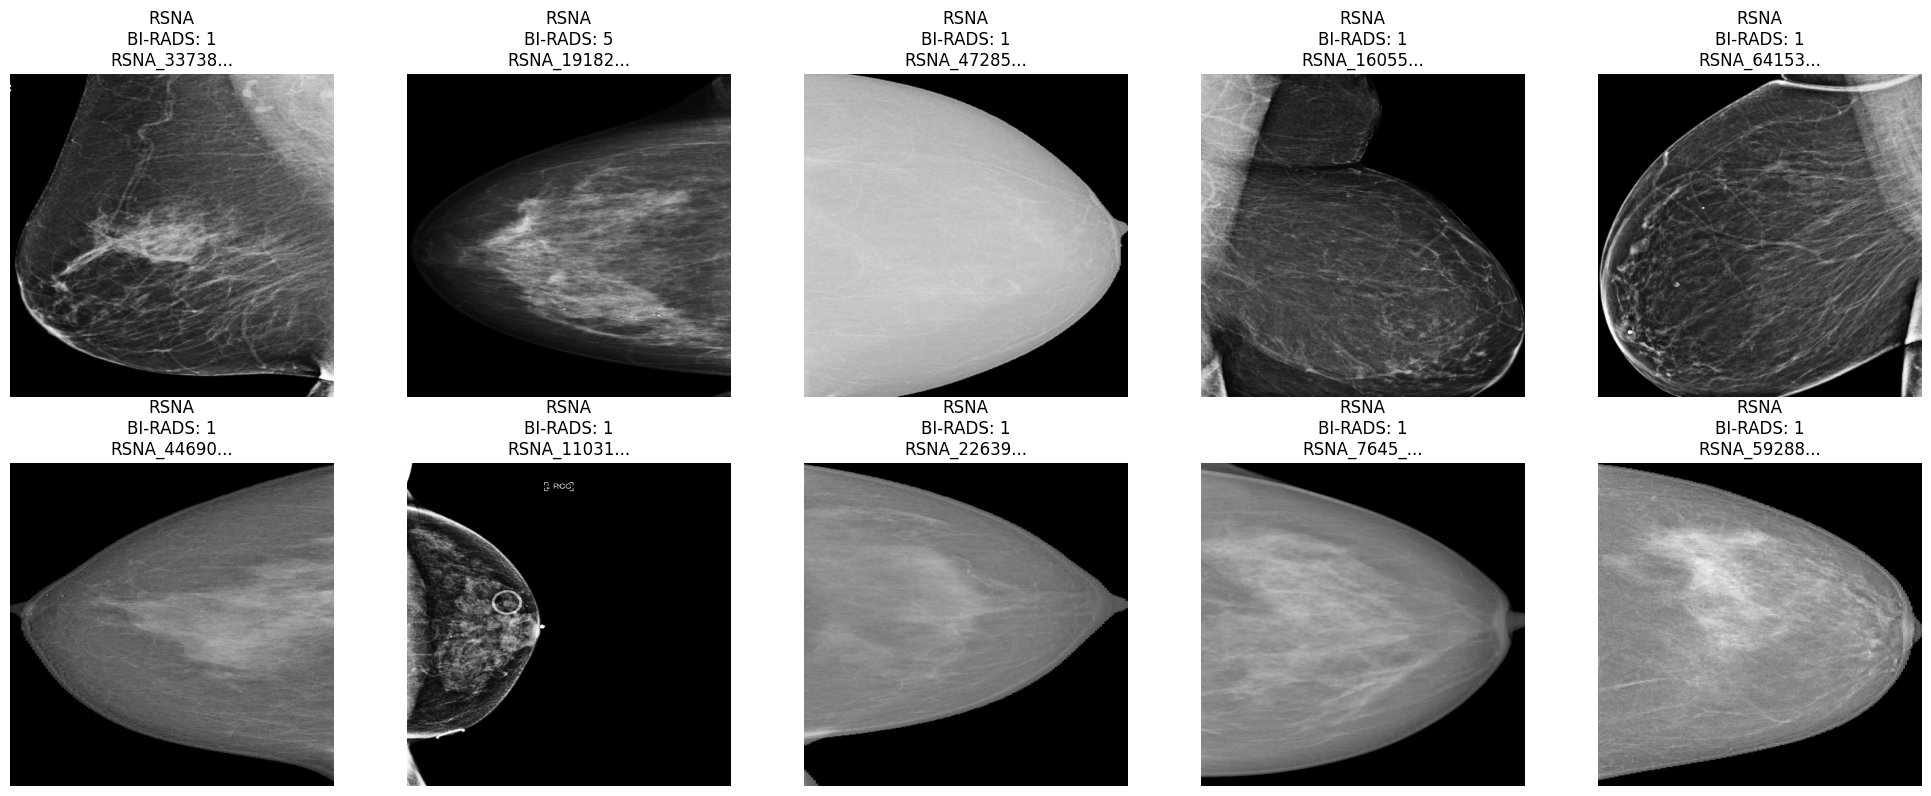


[4/4] ANALIZ SONUCU
Veri seti kullanima hazir. Goruntuler 512x512 boyutunda ve normalize edilmis durumda.
Model egitim asamasina gecilebilir.


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
from PIL import Image

# AYARLAR
BASE_DIR = '/content/tubitak_data'
IMAGES_DIR = f'{BASE_DIR}/cropped_images'
DRIVE_ZIP_PATH = '/content/drive/MyDrive/TUBITAK_CROPPED_DATASET.zip'
CSV_PATH = '/content/drive/MyDrive/TUBITAK_MASTER_CROPPED.csv'

print("DATA ENGINEER ANALYSIS: VERI SETI KONTROLU")
print("------------------------------------------------")

# 1. VERI YUKLEME (Gerekirse)
if not os.path.exists(IMAGES_DIR):
    print("[1/4] Veri seti Drive'dan yukleniyor...")
    os.makedirs(IMAGES_DIR, exist_ok=True)
    if os.path.exists(DRIVE_ZIP_PATH):
        with zipfile.ZipFile(DRIVE_ZIP_PATH, 'r') as z:
            z.extractall(IMAGES_DIR)
        print("   -> ZIP acildi ve hazir.")
    else:
        print("   HATA: Yedeklenmis ZIP dosyasi bulunamadi!")
else:
    print("[1/4] Veriler zaten diskte mevcut. Yukleme atlandi.")

# 2. META VERI ANALIZI
print("\n[2/4] Veri Dagilimi ve Istatistikler")
df = pd.read_csv(CSV_PATH)
physical_count = len(os.listdir(IMAGES_DIR))

print(f"   -> CSV Kayit Sayisi: {len(df)}")
print(f"   -> Fiziksel Dosya Sayisi: {physical_count}")

if len(df) == physical_count:
    print("   -> BUTUNLUK DURUMU: MUKEMMEL (Dosya sayilari eslesiyor)")
else:
    print(f"   -> BUTUNLUK DURUMU: UYARI ({abs(len(df)-physical_count)} dosya farkli)")

print("\n   -> Sinif Dagilimi (BI-RADS):")
print(df.groupby(['source', 'BIRADS']).size())

# 3. GORSEL KALITE KONTROLU (Rastgele 10 Ornek)
print("\n[3/4] Rastgele 10 Ornek Goruntuleniyor (Shuffle Check)...")

# Datasetten rastgele 10 ornek sec
samples = df.sample(10)

plt.figure(figsize=(20, 8))
for i, (idx, row) in enumerate(samples.iterrows()):
    img_path = os.path.join(IMAGES_DIR, row['filename'])
    try:
        img = Image.open(img_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{row['source']}\nBI-RADS: {row['BIRADS']}\n{row['filename'][:10]}...")
        plt.axis('off')
    except Exception as e:
        print(f"Hata: {row['filename']} acilamadi.")

plt.tight_layout()
plt.show()

print("\n[4/4] ANALIZ SONUCU")
print("Veri seti kullanima hazir. Goruntuler 512x512 boyutunda ve normalize edilmis durumda.")
print("Model egitim asamasina gecilebilir.")